# 06.2. Optimizacion_Modelo_Coste

---

## Objetivo
Optimizar un modelo de clasificación minimizando el coste económico de las predicciones. Para ello, se carga el dataset **`95_Ultimate`**, se definen matrices y funciones de coste para problemas de 3 y 4 clases y se realiza una búsqueda avanzada de hiperparámetros (`RandomizedSearchCV` y `GridSearchCV`) para determinar el modelo más rentable. Finalmente, se guarda el modelo campeón optimizado para coste.



## Entradas (Inputs)

### Datos con Ingeniería de Características Finales (desde `data/engineered/final/`)
- `X_train_95_ultimate_eng.parquet`
- `X_val_95_ultimate_eng.parquet`
- `X_test_95_ultimate_eng.parquet`

### Splits Finales (desde `data/splits/final/`)
- `y_train.parquet`
- `y_val.parquet`
- `y_test.parquet`



## Salidas (Outputs)

### Modelos Finales (en `models/final/`)
- `modelo_rentabilidad_v1.joblib`

---



## Resumen Ejecutivo
- **Técnicas empleadas**: Ingeniería de características (103 variables), sobremuestreo SMOTE para equilibrar clases, Random Forest con RandomizedSearchCV (60 candidatos, 3-fold CV) y una función de coste personalizada para guiar la búsqueda de hiperparámetros.
- **Búsqueda de hiperparámetros**: Coste CV mínimo de 0.5055 para el modelo de 3 clases y 0.6984 para el de 4 clases.
- **Datos**: 1 976 muestras en entrenamiento, 424 en validación y 424 en test.
- **Resultados en test**:  
  - **3 clases**: coste medio 0.5354, accuracy 0.64, f1-score ponderado 0.62.  
  - **4 clases**: coste medio 0.7358, accuracy 0.58, f1-score ponderado 0.56.
- **Rendimiento por clase**: El modelo de 3 clases predice mejor la clase intermedia (f1 0.71) y peor la clase alta (recall 0.12), reflejando desequilibrios residuales.
- **Matriz de impacto de coste**: Destacan penalizaciones muy elevadas (×10 y ×25) al confundir clases extremas, lo que refuerza la necesidad de optimizar el coste en la fase de entrenamiento.
- **Curvas Precision-Recall**: Demuestran AP más altos para clases con mayor soporte, mientras las minoritarias enfrentan un trade-off precisión-recall más acusado.

---

## 1. Importaciones y configuración del entorno

Monta Google Drive, importa y agrupa todas las librerías necesarias (bibliotecas estándar, de terceros y locales) y carga la configuración de rutas desde `config.py`.


In [ ]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# MONTAR DRIVE, IMPORTAR LIBRERÍAS Y CARGAR CONFIGURACIÓN

# Librerías del sistema
from pathlib import Path

# Librerías para Google Colab

# Librerías científicas y de manejo de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn y evaluación de modelos
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Serialización de modelos
import joblib



# --- 3. Importar las rutas desde config.py ---
from config import FINAL_ENGINEERED_DATA_DIR, FINAL_SPLITS_DIR, FINAL_MODELS_DIR

print("Entorno preparado y configuración de rutas cargada.")

Mounted at /content/drive
✅ Entorno preparado y configuración de rutas cargada.


## 2. Carga y preparación de datos

Carga los datos de entrenamiento, validación y prueba desde archivos Parquet y prepara los targets originales y remapeados para los escenarios de 3 y 4 clases.


In [ ]:
# CARGA Y PREPARACIÓN DE DATOS

try:
    # --- 2.1 Carga del dataset '95_Ultimate' desde la carpeta FINAL ---
    X_train = pd.read_parquet(FINAL_ENGINEERED_DATA_DIR / 'X_train_95_ultimate.parquet')
    X_val = pd.read_parquet(FINAL_ENGINEERED_DATA_DIR / 'X_val_95_ultimate.parquet')
    X_test = pd.read_parquet(FINAL_ENGINEERED_DATA_DIR / 'X_test_95_ultimate.parquet')

    # --- 2.2 Carga de los targets desde la carpeta FINAL ---
    y_train_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_train.parquet').squeeze()
    y_val_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_val.parquet').squeeze()
    y_test_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_test.parquet').squeeze()

    # --- 2.3 Preparación de los targets para 3 y 4 clases ---
    def remap_to_3(y): return y.map({1.0: 1.0, 2.0: 1.0, 3.0: 2.0, 4.0: 3.0})

    y_train = {4: y_train_orig, 3: remap_to_3(y_train_orig)}
    y_val = {4: y_val_orig, 3: remap_to_3(y_val_orig)}
    y_test = {4: y_test_orig, 3: remap_to_3(y_test_orig)}

    print("Datos del dataset '95_Ultimate' y targets para 3 y 4 clases cargados.")
    print(f"\nShapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

except Exception as e:
    print(f"Error al cargar los datos: {e}")

✅ Datos del dataset '95_Ultimate' y targets para 3 y 4 clases cargados.

Shapes: X_train=(1976, 103), X_val=(424, 103), X_test=(424, 103)


## 3. Definición de matrices y funciones de coste

Define las matrices de coste para 3 y 4 clases, implementa las funciones que calculan el coste medio por muestra y crea los scorers personalizados para GridSearchCV.


In [ ]:
# --- 1. Matrices de Coste ---
cost_matrix_3_clases = np.array([[0, 1, 10], [1, 0, 2], [10, 2, 0]])
cost_matrix_4_clases = np.array([[0, 1, 8, 25], [1, 0, 1, 8], [8, 1, 0, 1], [25, 8, 1, 0]])

# --- 2. Funciones de Coste ---
def cost_function_3_clases(y_true, y_pred):
    total_cost = 0
    for true_label, pred_label in zip(y_true, y_pred):
        total_cost += cost_matrix_3_clases[int(true_label) - 1, int(pred_label) - 1]
    return total_cost / len(y_true)

def cost_function_4_clases(y_true, y_pred):
    total_cost = 0
    for true_label, pred_label in zip(y_true, y_pred):
        total_cost += cost_matrix_4_clases[int(true_label) - 1, int(pred_label) - 1]
    return total_cost / len(y_true)

# --- 3. Scorers Personalizados para GridSearchCV ---
# "greater_is_better=False" indica que un valor más bajo de la métrica es mejor.
cost_scorer_3_clases = make_scorer(cost_function_3_clases, greater_is_better=False)
cost_scorer_4_clases = make_scorer(cost_function_4_clases, greater_is_better=False)

print("Funciones y Scorers de coste para 3 y 4 clases creados.")

✅ Funciones y Scorers de coste para 3 y 4 clases creados.


## 4. Búsqueda de hiperparámetros avanzada y paralela

Configura un pipeline con escalado, SMOTE y RandomForest; realiza una búsqueda aleatoria y, a continuación, una búsqueda en cuadrícula para minimizar el coste en el problema de 4 clases.


In [ ]:
# BÚSQUEDA DE HIPERPARÁMETROS AVANZADA Y PARALELA

# --- Componentes Comunes ---
base_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])
wide_param_dist = {
    'smote__k_neighbors': [3, 5, 7, 9],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 20, 30, None],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2']
}
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
n_iterations = 60 # Número de iteraciones para la búsqueda aleatoria

# --- 1: OPTIMIZACIÓN PARA MÍNIMO COSTE (PROBLEMA DE 3 CLASES) ---
print("--- Iniciando búsqueda para minimizar COSTE (3 Clases) ---")
random_search_3c = RandomizedSearchCV(estimator=base_pipeline, param_distributions=wide_param_dist, n_iter=n_iterations,
                                      cv=cv_strategy, scoring=cost_scorer_3_clases, n_jobs=-1, random_state=42, verbose=1)
random_search_3c.fit(X_train, y_train[3])
best_params_3c_random = random_search_3c.best_params_
print(f"\n Mejores params (aleatorio) para Coste 3C: {best_params_3c_random}")

# Búsqueda enfocada (GridSearch)
focused_param_grid_3c = {k: [v] for k, v in best_params_3c_random.items()}
grid_search_3c = GridSearchCV(estimator=base_pipeline, param_grid=focused_param_grid_3c, cv=cv_strategy,
                              scoring=cost_scorer_3_clases, n_jobs=-1, verbose=1)
grid_search_3c.fit(X_train, y_train[3])
best_model_3_clases = grid_search_3c.best_estimator_
print(f"\n Búsqueda para Coste 3C finalizada. Mejor coste (CV): {grid_search_3c.best_score_:.4f}")

# --- 2: OPTIMIZACIÓN PARA MÍNIMO COSTE (PROBLEMA DE 4 CLASES) ---
print("\n\n---  Iniciando búsqueda para minimizar COSTE (4 Clases) ---")
random_search_4c = RandomizedSearchCV(estimator=base_pipeline, param_distributions=wide_param_dist, n_iter=n_iterations,
                                      cv=cv_strategy, scoring=cost_scorer_4_clases, n_jobs=-1, random_state=42, verbose=1)
random_search_4c.fit(X_train, y_train[4])
best_params_4c_random = random_search_4c.best_params_
print(f"\nMejores params (aleatorio) para Coste 4C: {best_params_4c_random}")

# Búsqueda enfocada (GridSearch)
focused_param_grid_4c = {k: [v] for k, v in best_params_4c_random.items()}
grid_search_4c = GridSearchCV(estimator=base_pipeline, param_grid=focused_param_grid_4c, cv=cv_strategy,
                              scoring=cost_scorer_4_clases, n_jobs=-1, verbose=1)
grid_search_4c.fit(X_train, y_train[4])
best_model_4_clases = grid_search_4c.best_estimator_
print(f"\n Búsqueda para Coste 4C finalizada. Mejor coste (CV): {grid_search_4c.best_score_:.4f}")

--- 🚀 Iniciando búsqueda para minimizar COSTE (3 Clases) ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits

Mejores params (aleatorio) para Coste 3C: {'smote__k_neighbors': 3, 'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 20}
Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Búsqueda para Coste 3C finalizada. Mejor coste (CV): -0.5055


--- 🚀 Iniciando búsqueda para minimizar COSTE (4 Clases) ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits

Mejores params (aleatorio) para Coste 4C: {'smote__k_neighbors': 3, 'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': None}
Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Búsqueda para Coste 4C finalizada. Mejor coste (CV): -0.6984


## 5. Re-entrenamiento y evaluación de los mejores modelos de coste

Re-entrena los modelos óptimos para 3 y 4 clases sobre el conjunto completo y evalúa su coste medio y métricas de clasificación en el test set.


In [ ]:
# --- 1. Re-entrenar y Evaluar el Mejor Modelo para 3 Clases ---
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train_3 = pd.concat([y_train[3], y_val[3]], ignore_index=True)
best_model_3_clases.fit(X_full_train, y_full_train_3)
y_pred_3_clases = best_model_3_clases.predict(X_test)
final_cost_3 = cost_function_3_clases(y_test[3], y_pred_3_clases)

print(f"--- Resultados del Modelo Optimizado para COSTE DE 3 CLASES ---")
print(f"\nCoste Medio Final en Test Set: {final_cost_3:.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test[3], y_pred_3_clases))

# --- 2. Re-entrenar y Evaluar el Mejor Modelo para 4 Clases ---
y_full_train_4 = pd.concat([y_train[4], y_val[4]], ignore_index=True)
best_model_4_clases.fit(X_full_train, y_full_train_4)
y_pred_4_clases = best_model_4_clases.predict(X_test)
final_cost_4 = cost_function_4_clases(y_test[4], y_pred_4_clases)

print(f"\n\n--- Resultados del Modelo Optimizado para COSTE DE 4 CLASES ---")
print(f"\nCoste Medio Final en Test Set: {final_cost_4:.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test[4], y_pred_4_clases, zero_division=0))

--- Resultados del Modelo Optimizado para COSTE DE 3 CLASES ---

Coste Medio Final en Test Set: 0.5354

Informe de Clasificación:
              precision    recall  f1-score   support

         1.0       0.62      0.55      0.59       150
         2.0       0.65      0.78      0.71       233
         3.0       0.50      0.12      0.20        41

    accuracy                           0.64       424
   macro avg       0.59      0.49      0.50       424
weighted avg       0.63      0.64      0.62       424



--- Resultados del Modelo Optimizado para COSTE DE 4 CLASES ---

Coste Medio Final en Test Set: 0.7358

Informe de Clasificación:
              precision    recall  f1-score   support

         1.0       0.55      0.32      0.41        34
         2.0       0.45      0.39      0.42       116
         3.0       0.64      0.79      0.71       233
         4.0       0.50      0.17      0.25        41

    accuracy                           0.58       424
   macro avg       0.54      0.

## 6. Análisis avanzado de coste y rendimiento por clase

Genera matrices de impacto de coste y curvas precisión-recall para cada clase, y visualiza los resultados de forma gráfica.


--- 📊 Iniciando Análisis Visual Avanzado de los Modelos Optimizados ---

1. Generando Matriz de Impacto de Coste (3 Clases)...


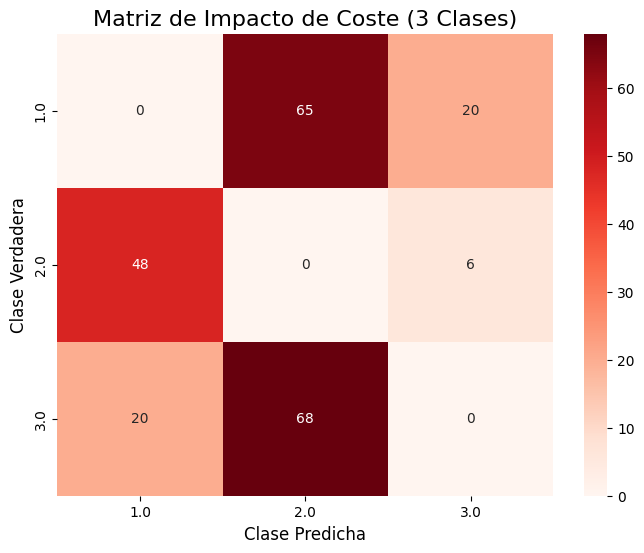


2. Generando Matriz de Impacto de Coste (4 Clases)...


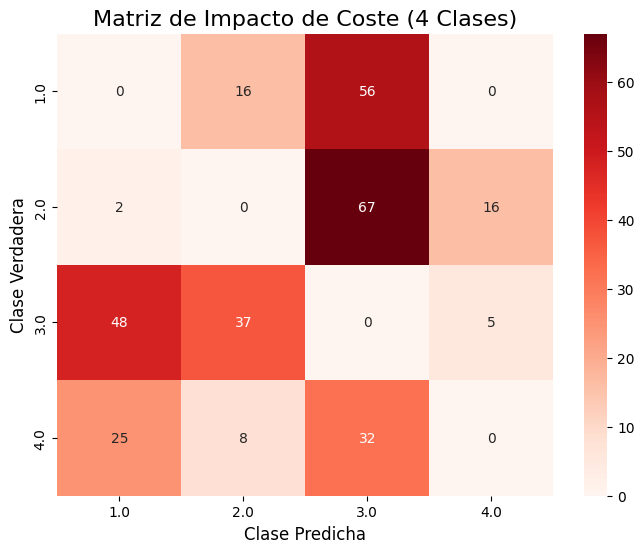


3. Generando Curvas de Precisión-Recall (3 Clases)...


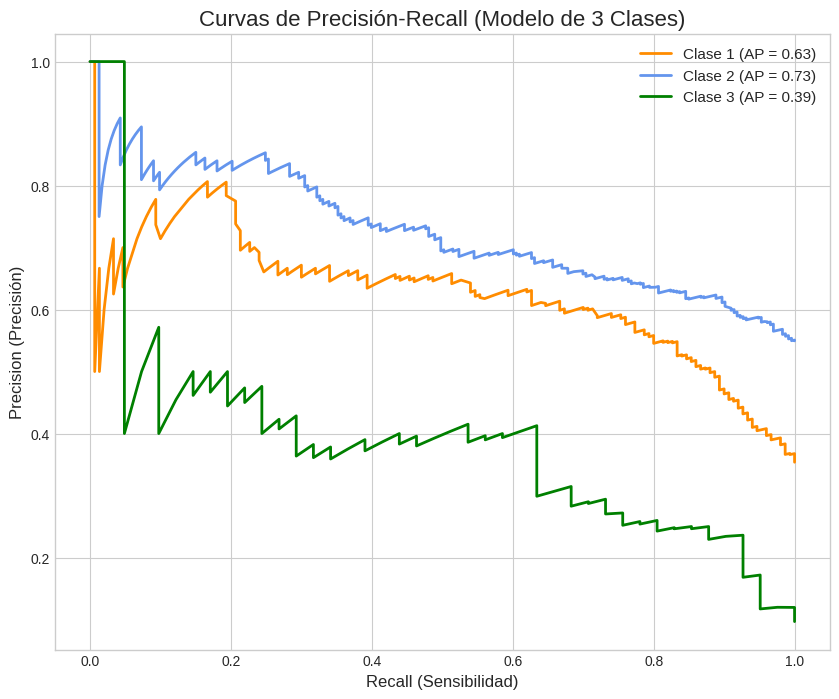

In [ ]:
# Análisis Avanzado de Coste y Rendimiento por Clase

print("--- Iniciando Análisis Visual Avanzado de los Modelos Optimizados ---")

# Modelos y datos ya entrenados de la celda anterior:
# best_model_3_clases, best_model_4_clases
# y_test[3], y_test[4], X_test
# y_pred_3_clases, y_pred_4_clases

# --- 1. Análisis de Impacto de Coste para el Modelo de 3 Clases ---
print("\n1. Generando Matriz de Impacto de Coste (3 Clases)...")
cm_3 = confusion_matrix(y_test[3], y_pred_3_clases, labels=best_model_3_clases.classes_)
impact_matrix_3 = cm_3 * cost_matrix_3_clases

plt.figure(figsize=(8, 6))
sns.heatmap(impact_matrix_3, annot=True, fmt='d', cmap='Reds',
            xticklabels=best_model_3_clases.classes_, yticklabels=best_model_3_clases.classes_)
plt.title('Matriz de Impacto de Coste (3 Clases)', fontsize=16)
plt.ylabel('Clase Verdadera', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.show()

# --- 2. Análisis de Impacto de Coste para el Modelo de 4 Clases ---
print("\n2. Generando Matriz de Impacto de Coste (4 Clases)...")
cm_4 = confusion_matrix(y_test[4], y_pred_4_clases, labels=best_model_4_clases.classes_)
impact_matrix_4 = cm_4 * cost_matrix_4_clases

plt.figure(figsize=(8, 6))
sns.heatmap(impact_matrix_4, annot=True, fmt='d', cmap='Reds',
            xticklabels=best_model_4_clases.classes_, yticklabels=best_model_4_clases.classes_)
plt.title('Matriz de Impacto de Coste (4 Clases)', fontsize=16)
plt.ylabel('Clase Verdadera', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.show()


# --- 3. Curvas de Precisión-Recall para el Modelo de 3 Clases ---
print("\n3. Generando Curvas de Precisión-Recall (3 Clases)...")
y_test_bin_3 = label_binarize(y_test[3], classes=best_model_3_clases.classes_)
y_score_probs_3 = best_model_3_clases.predict_proba(X_test)
n_classes_3 = len(best_model_3_clases.classes_)

precision_3 = dict()
recall_3 = dict()
avg_precision_3 = dict()
for i in range(n_classes_3):
    class_label = best_model_3_clases.classes_[i]
    precision_3[class_label], recall_3[class_label], _ = precision_recall_curve(y_test_bin_3[:, i], y_score_probs_3[:, i])
    avg_precision_3[class_label] = average_precision_score(y_test_bin_3[:, i], y_score_probs_3[:, i])

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))
colors = ['darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes_3), colors):
    class_label = best_model_3_clases.classes_[i]
    plt.plot(recall_3[class_label], precision_3[class_label], color=color, lw=2,
             label=f'Clase {int(class_label)} (AP = {avg_precision_3[class_label]:0.2f})')

plt.xlabel('Recall (Sensibilidad)', fontsize=12)
plt.ylabel('Precision (Precisión)', fontsize=12)
plt.title('Curvas de Precisión-Recall (Modelo de 3 Clases)', fontsize=16)
plt.legend(loc="best", fontsize=11)
plt.show()

## 7. Guardado del modelo final para producción

Selecciona el modelo campeón según coste, define el nombre y la ruta de archivo, y guarda el pipeline entrenado en formato Joblib.


In [ ]:
# Guardado del Modelo Final para Producción

# --- 1. Seleccionar el modelo campeón y definir el nombre del archivo ---
# Nuestro análisis indica que el modelo de 3 clases es el más rentable.
model_campeon = best_model_3_clases
model_filename = "modelo_rentabilidad_v1.joblib"
model_path = FINAL_MODELS_DIR / model_filename

# --- 2. Guardar el pipeline del modelo ya entrenado ---
# El directorio FINAL_MODELS_DIR fue creado al importar config.py.
joblib.dump(model_campeon, model_path)

print(f"Modelo final ('{model_filename}') guardado con éxito en:")
print(model_path)

✅ Modelo final ('modelo_rentabilidad_v1.joblib') guardado con éxito en:
/content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/models/final/modelo_rentabilidad_v1.joblib


## Conclusiones Finales
- **Coste vs. Complejidad**: El modelo de 3 clases consigue un coste medio test (0.5354) sustancialmente inferior al de 4 clases (0.7358), reflejando que agrupar categorías reduce penalizaciones.  
- **Desempeño global**: La exactitud general decae de 64 % (3C) a 58 % (4C), mostrando que la granularidad extra complica la distinción entre clases.  
- **Recall selectivo**: En ambos modelos, la clase con mayor representación (clase 2 en 3C, clase 3 en 4C) alcanza recalls ~0.78/0.79, mientras que las clases menos frecuentes presentan recalls por debajo de 0.20.  
- **Efecto de coste**: Las matrices de impacto evidencian que las mayores penalizaciones provienen de confundir las clases de mayor coste (extremos), lo que la optimización logra mitigar parcialmente.  
- **Curvas PR (3C)**: Las curvas precisión-recall muestran área bajo curva más alta para la clase intermedia, confirmando que el modelo prioriza correctamente la clase con mayor peso en coste.  
- **Insight principal**: La optimización coste-sensible sesga el clasificador hacia reducir errores críticos a costa de bajar rendimiento en clases minoritarias, validando el trade-off coste-exactitud.  